In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous

class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [40]:
# here we are able to sample rv exactly as in publication
N, beta = 1000,  1/2 # run with n = 1000000
# beta = 1/2 because we want to have a finite mean and for this beta we could check that the code is good
r = frechet.rvs(beta, size=N)
# np.mean(r)
# + histogram of data's

AttributeError: 'list' object has no attribute 'rvs'

In [ ]:
# beta = 1/2 because we want to have a finite mean and for this beta we could check that the code is good

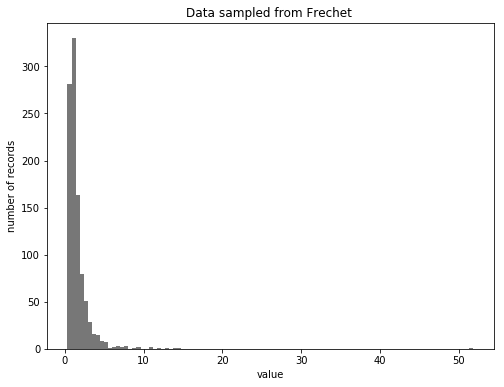

In [39]:
# histogram of data
fig, ax = plt.subplots(figsize=[8,6])

# set plot title
ax.set_title("Data sampled from Frechet ")

# set x-axis name
ax.set_xlabel("value")

# set y-axis name
ax.set_ylabel("number of records")

# create histogram within output
Nb, bins, patches = ax.hist(r, bins=100, color="#777777") #initial color of all bins

# Iterate through all histogram elements
# each element in this interation is one patch on the histogram, where:
# - bin_size - number of records in current bin
# - bin - value of current bin (x-axis)
# - patch - a rectangle, object of class matplotlib.patches.Patch
# more details on patch properties: [visit this link][1]

for bin_size, bin, patch in zip(Nb, bins, patches):
    if bin_size == 100:
        patch.set_facecolor("#FF000")
        patch.set_label("something")

plt.show()

In [4]:
from prettytable import PrettyTable
m = 3 # how much we round
t = PrettyTable(['pr.distr.', 'mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%'])
t.add_row(['Fréchet',
           "%.3f" % round(np.mean(r),m),
           "%.3f" % round(np.std(r),m),
           "%.3f" % round(np.percentile(r, 2.5),m), 
           "%.3f" % round(np.percentile(r, 25),m), 
           "%.3f" % round(np.percentile(r, 50),m), 
           "%.3f" % round(np.percentile(r, 75),m), 
           "%.3f" % round(np.percentile(r, 97.5),m)])
# t.add_row(['Bob', 19])
print(t)

+-----------+-------+-------+-------+-------+-------+-------+-------+
| pr.distr. |  mean |   sd  |  2.5% |  25%  |  50%  |  75%  | 97.5% |
+-----------+-------+-------+-------+-------+-------+-------+-------+
|  Fréchet  | 1.639 | 2.133 | 0.516 | 0.833 | 1.162 | 1.794 | 5.227 |
+-----------+-------+-------+-------+-------+-------+-------+-------+


In [5]:
# we need a function to get a excesses
def k_greatest_values(a,k):
    """returns k greatest elements from the list and k-1 value starting from which we consider values to be extreme"""
    u = np.sort(a, axis=None)[-1-k]
    a = np.sort(a, axis=None)[-1-k+1:]
    a = asarray([a-u for x in a])
    return(a[1].tolist(), u) # u the starting value from which we consider others as excesses

In [6]:
k = 100 # number of excesses
frechet, u = k_greatest_values(r, k)
# frechet # so we recover  k = 100 excesses sampled from Frechet distribution

In [7]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      //return -(1+1/c)*log(1+c*y2);
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  // above distribution is a special case of the distribution in the paper for alpha = beta = 1 / c
  // c = 1/beta
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //real c; 
  real alpha;
  real beta;
}
model {
  // Priors
  // no priors - we assume improper priors on params
  // c ~ uniform(0,1);
  alpha ~ gamma(2,2);
  beta ~ gamma(2,2);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }

}
generated quantities{}
"""

In [ ]:
# the same prior in gpd and fischer to compare

In [8]:
data = dict(N = k,  y = frechet) 
fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.


Inference for Stan model: anon_model_5551b5fb5994a23fc671300ba4c16b27.
1 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=800.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   1.59    0.03   0.32   1.09   1.36   1.54   1.78    2.3    129    1.0
beta    1.72    0.04    0.5   0.94   1.37   1.63    2.0   2.88    130   1.01
lp__  -174.7    0.09   1.08 -177.6 -175.1 -174.3 -173.9 -173.6    144    1.0

Samples were drawn using NUTS at Sat May 26 13:04:11 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
traceplot_beta = list(fit.extract().values())[1].tolist() 
traceplot_alpha = list(fit.extract().values())[0].tolist()
beta = np.mean(list(fit.extract().values())[1].tolist())
alpha = np.mean(list(fit.extract().values())[0].tolist())
gamma = 1 / alpha 
print(" alpha = ", alpha, "\n beta = ", beta, "\n gamma = ", gamma)


 alpha =  1.5872211303156485 
 beta =  1.7151449220144752 
 gamma =  0.6300319349964371


In [43]:
# table to compare with table before (beginning)
def quantile_GPD(N, k, p, beta, gamma, u):
    quant = u + beta*( ( N * p / k )**( -gamma ) - 1 ) 
    return( quant) # p = 0.05


In [44]:
# check different levels of quantiles to compare them with the original ones in the pretty table above

In [59]:
# we check the values we will use to obtain quantiles 
quant_GPD = [" N = ", N," k = ",  k," beta = ",  beta," gamma = ",  gamma, " u = ", u]
print(quant_GPD)

q = [0.025, 0.25, 0.5, 0.75, 0.975]
quant_GPD = np.zeros(len(q)) 
for i in range(len(q)):
    quant_GPD[i] = quantile_GPD(N, k, q[i], beta, gamma, u) # p=0.05 check more values of quantiles 2.5%, 25 % ....

[' N = ', 1000, ' k = ', 100, ' beta = ', 0.5, ' gamma = ', 0.6300319349964371, ' u = ', 2.8978948666519035]


In [60]:
quant_GPD

array([3.59542659, 2.67860306, 2.57927787, 2.53838747, 2.51698218])

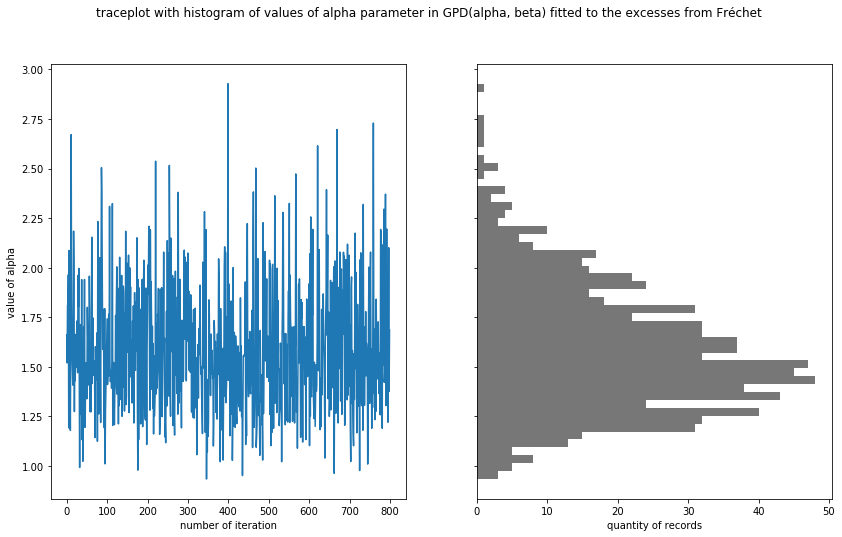

In [91]:
# plot traceplots of parameters with the histogram displayed on the right side and rotated

# define window size, output and axes
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])

# set x-axis name
ax[0].set_xlabel("number of iteration")
ax[0].plot(traceplot_alpha)
ax[0].set_ylabel("value of alpha")

# set y-axis name
ax[1].set_xlabel("quantity of records")
# ax[1].set_ylabel("number of records")

plt.suptitle('traceplot with histogram of values of alpha parameter in GPD(alpha, beta) fitted to the excesses from Fréchet')

# titles of subplots, here we don't use it 
# ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
# ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")


# create histogram within output
Nb, bins, patches = ax[1].hist(traceplot_alpha, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins

plt.show()

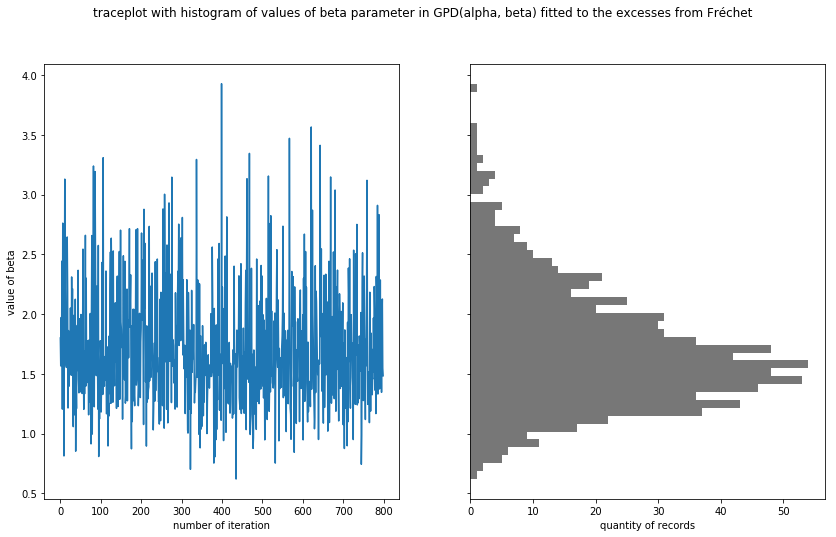

In [89]:
# plot traceplots of parameters with the histogram displayed on the right side and rotated

# define window size, output and axes
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])

# set x-axis name
ax[0].set_xlabel("number of iteration")
ax[0].plot(traceplot_beta)
ax[0].set_ylabel("value of beta")

# set y-axis name
ax[1].set_xlabel("quantity of records")
# ax[1].set_ylabel("number of records")

plt.suptitle('traceplot with histogram of values of beta parameter in GPD(alpha, beta) fitted to the excesses from Fréchet')

# titles of subplots, here we don't use it 
# ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
# ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")


# create histogram within output
Nb, bins, patches = ax[1].hist(traceplot_beta, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins

plt.show()

In [94]:
Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
  
// to recover more general distribution of Fisher parametrized by three parameters we need to multiply the above distribution 
// by: df1**df1/2
// we have alpha1,2 = df1,2/2, beta = df2/df1
}

data { 
  int N;
  real y[N]; // points sampled from fisher in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //parameters of the Fisher
  //real df1;
  //real df2;
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta;
  
}
model {
  // when we deliberately do not specify priors then Stan works with improper priors
  alpha1 ~ gamma(2,2);
  alpha2 ~ gamma(2,2);
  beta ~ gamma(2,2);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}

generated quantities{}
"""

In [95]:
data = dict(N = k,  y = frechet) 
fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.


Inference for Stan model: anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5.
1 chains, each with iter=1000; warmup=200; thin=1; 
post-warmup draws per chain=800, total post-warmup draws=800.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha1   0.94  5.9e-3   0.14    0.7   0.84   0.93   1.03   1.23    543    1.0
alpha2   1.54    0.02   0.32   1.02   1.31   1.49   1.72   2.29    390    1.0
beta     1.82    0.03   0.62   0.84   1.39   1.73   2.17   3.28    430    1.0
lp__   -176.2    0.06   1.16 -179.3 -176.7 -175.9 -175.3 -174.9    324    1.0

Samples were drawn using NUTS at Sat May 26 13:56:28 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [96]:
traceplot_beta = list(fit.extract().values())[2].tolist()
traceplot_alpha1 = list(fit.extract().values())[1].tolist()
traceplot_alpha2 = list(fit.extract().values())[0].tolist()
beta = np.mean(list(fit.extract().values())[2].tolist())
alpha2 = np.mean(list(fit.extract().values())[1].tolist())
alpha1 = np.mean(list(fit.extract().values())[0].tolist())
print(" alpha1 = ", alpha1, "\n alpha2 = ", alpha2, "\n beta = ", beta)
# gamma = 1 / alpha 

 alpha1 =  0.9375169418849103 
 alpha2 =  1.5364498337267938 
 beta =  1.8204177699370545


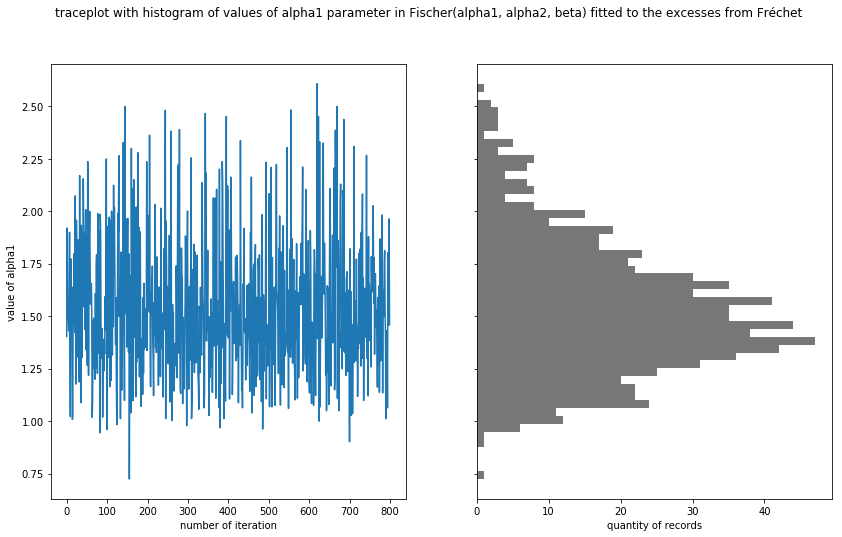

In [100]:
# plot traceplots of parameters with the histogram displayed on the right side and rotated

# define window size, output and axes
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])

# set x-axis name
ax[0].set_xlabel("number of iteration")
ax[0].plot(traceplot_alpha1)
ax[0].set_ylabel("value of alpha1")

# set y-axis name
ax[1].set_xlabel("quantity of records")
# ax[1].set_ylabel("number of records")

plt.suptitle('traceplot with histogram of values of alpha1 parameter in Fischer(alpha1, alpha2, beta) fitted to the excesses from Fréchet')

# titles of subplots, here we don't use it 
# ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
# ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")


# create histogram within output
Nb, bins, patches = ax[1].hist(traceplot_alpha1, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins

plt.show()

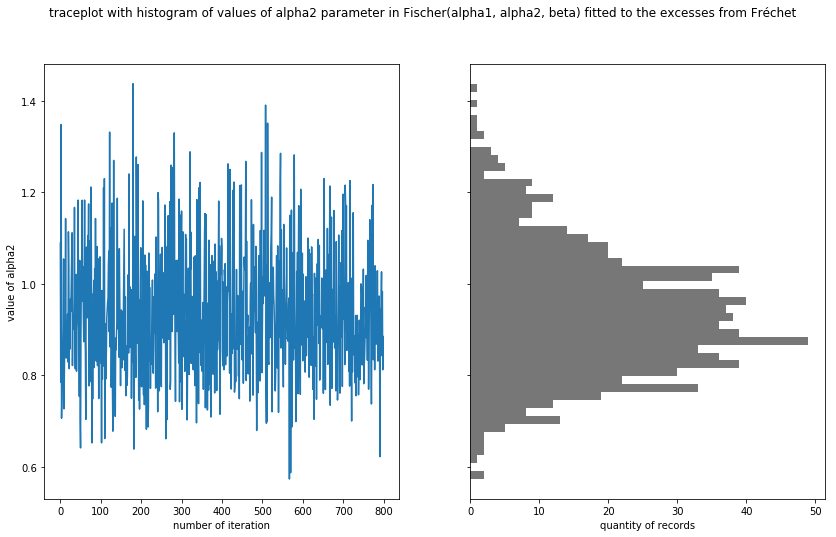

In [101]:
# plot traceplots of parameters with the histogram displayed on the right side and rotated

# define window size, output and axes
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])

# set x-axis name
ax[0].set_xlabel("number of iteration")
ax[0].plot(traceplot_alpha2)
ax[0].set_ylabel("value of alpha2")

# set y-axis name
ax[1].set_xlabel("quantity of records")
# ax[1].set_ylabel("number of records")

plt.suptitle('traceplot with histogram of values of alpha2 parameter in Fischer(alpha1, alpha2, beta) fitted to the excesses from Fréchet')

# titles of subplots, here we don't use it 
# ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
# ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")


# create histogram within output
Nb, bins, patches = ax[1].hist(traceplot_alpha2, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins

plt.show()

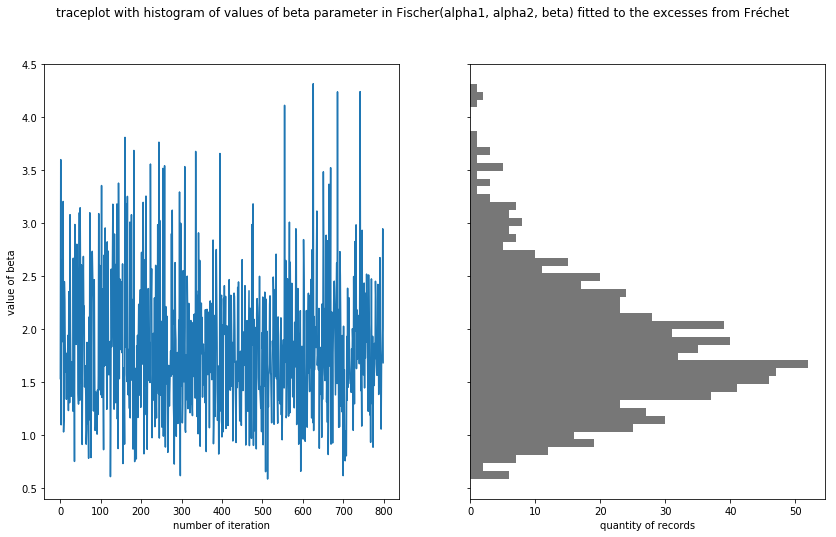

In [102]:
# plot traceplots of parameters with the histogram displayed on the right side and rotated

# define window size, output and axes
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])

# set x-axis name
ax[0].set_xlabel("number of iteration")
ax[0].plot(traceplot_beta)
ax[0].set_ylabel("value of beta")

# set y-axis name
ax[1].set_xlabel("quantity of records")
# ax[1].set_ylabel("number of records")

plt.suptitle('traceplot with histogram of values of beta parameter in Fischer(alpha1, alpha2, beta) fitted to the excesses from Fréchet')

# titles of subplots, here we don't use it 
# ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
# ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")


# create histogram within output
Nb, bins, patches = ax[1].hist(traceplot_beta, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins

plt.show()

In [ ]:
print("Below tries to average over multiple sets of excesses, for some reason it doesn't work")

In [ ]:
def quantile_Fischer(N, k, p, beta, gamma, u):
    return( u + beta*( ( N * p / k )**( -gamma ) - 1 ) ) # p = 0.05


In [ ]:
t = frechet.rvs(beta, size=N)

In [ ]:
t

In [ ]:
#ok, now we generate multiple datasets to be able to average over all the results
n = 20 # number of datasets we investigate

for i in range(n):
    t = frechet.rvs(beta, size=N)
    r = np.column_stack((r, t)) # 20 replications of datas from frechet distribution in columns


In [ ]:
t = frechet.rvs(beta, size=N)# why here it doesn't work while before it worked well?

In [ ]:
import numpy as np
a = np.array([1,2,3,4,5])
p = np.percentile(a, 50) # return 50th percentile, e.g median.
print p
3.0